In [2]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
h, w = 512, 512
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import cv2
import collections
import torch.nn.functional as F


In [3]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)


In [6]:
sample_img = np.random.rand(3, 512, 512)
sample_mask = np.random.rand(29, 512, 512)
output = dense_crf(sample_mask, sample_img, n_classes=29)

In [9]:
import sys
sys.path.insert(0, "/opt/ml/level2_cv_semanticsegmentation-cv-08")
import augmentations

tf = getattr(augmentations, "base_augmentation")(512)

In [10]:
imgs = glob.glob("/opt/ml/data/test/DCM/**/*.png")
img = imgs[np.random.randint(len(imgs))]
original_img = cv2.imread(img)
img = original_img / 255.
img = tf(image=img)['image']
img = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().cuda()

In [14]:
img.shape

torch.Size([1, 3, 512, 512])

In [11]:
model = torch.load("/opt/ml/level2_cv_semanticsegmentation-cv-08/model_dir/unet++_regnety-040_512_base/best.pt")

In [12]:
outputs_logits = model(img)
if isinstance(outputs_logits, collections.OrderedDict):
    outputs_logits = outputs_logits["out"]
# outputs = F.interpolate(outputs_logits, size=(2048, 2048), mode="bilinear")
outputs = torch.sigmoid(outputs_logits)
outputs = (outputs > 0.5).detach().cpu().numpy()[0]

In [13]:
outputs_logits = outputs_logits.detach().cpu().numpy()[0]
outputs_logits.shape

(29, 512, 512)

In [14]:
img_origin = img[0].detach().cpu().numpy()

In [15]:
img_origin.shape

(3, 512, 512)

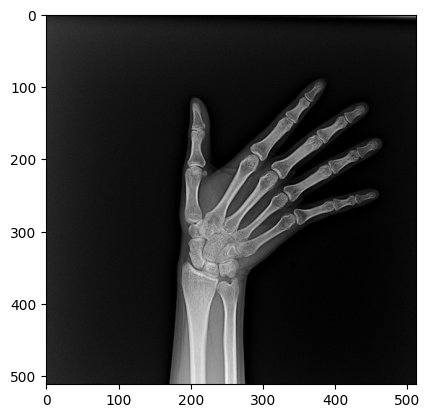

In [27]:
plt.imshow(img_origin.transpose(1, 2, 0))

In [16]:
def dense_crf(probs, img=None, n_classes=29, n_iters=10, scale_factor=1):
    c,h,w = probs.shape
    
    if img is not None:
        assert(img.shape[1:3] == (h, w))
        img = np.transpose(img,(1,2,0)).copy(order='C')
        img = np.uint8(255 * img)

    d = dcrf.DenseCRF2D(w, h, n_classes) # Define DenseCRF model.

    unary = unary_from_softmax(probs)
    unary = np.ascontiguousarray(unary)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=(3,3), compat=10)
    d.addPairwiseBilateral(sxy=10, srgb=5, rgbim=np.copy(img), compat=10)
    Q = d.inference(n_iters)

    preds = np.array(Q, dtype=np.float32).reshape((n_classes, h, w))
    return preds

In [19]:
output = dense_crf(outputs_logits, img_origin, n_classes=29, n_iters=1, scale_factor=1)

Text(0.5, 1.0, 'CRF output')

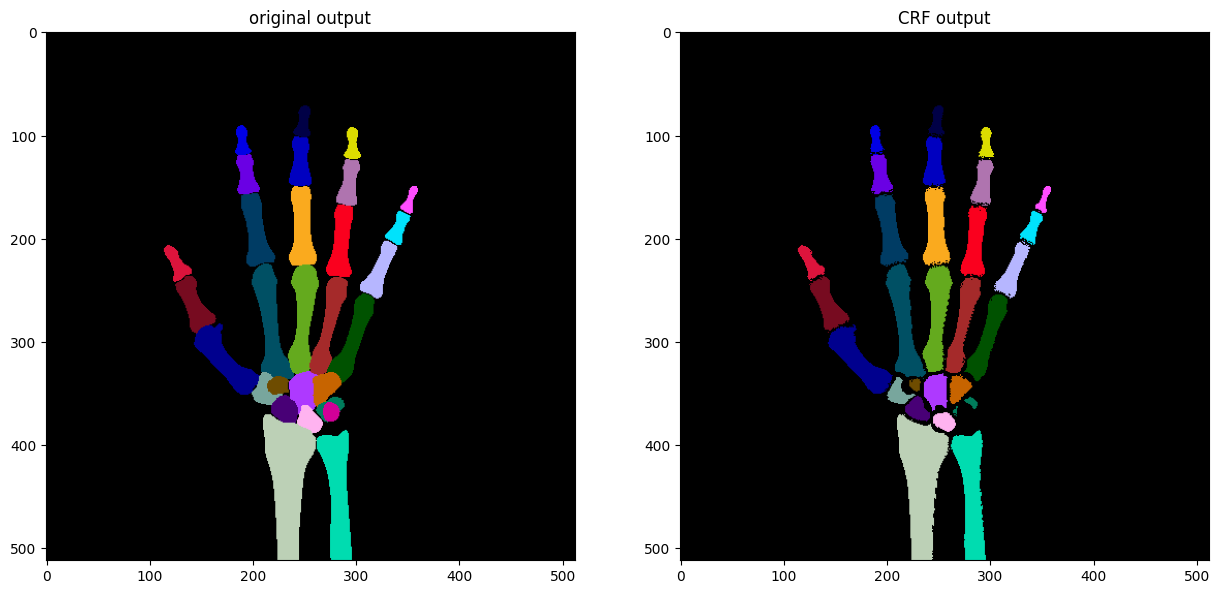

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 9))
axes[0].imshow(label2rgb(outputs))
axes[0].set_title("original output")
axes[1].imshow(label2rgb(output))
axes[1].set_title("CRF output")

In [53]:
output.shape

(29, 512, 512)

In [67]:
outputs.shape

(1, 29, 512, 512)

In [65]:
label2rgb(outputs).shape

(29, 512, 512, 3)